In [35]:
import numpy as np
import pandas as pd

In [36]:
data_path = 'survey_results.csv'
raw_df= pd.read_csv(data_path)

In [37]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 13 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype 
---  ------                                                                                                                  --------------  ----- 
 0   Which age group do you belong to?                                                                                       50 non-null     object
 1   What is your gender?                                                                                                    50 non-null     object
 2   Which category do you currently belong to?                                                                              50 non-null     object
 3   Which of the following best describes you?                                                                              50 non-null     object
 4   Whic

In [38]:
target_df = raw_df.copy()
preprocessed_df = target_df.copy()

In [39]:
def check_percentage(df, col, show = False):
  counts = df[col].value_counts()
  percentages = (counts / counts.sum()) * 100
  for index, value in percentages.items():
    if value < 5 or show:
        print('_'*80)
        print(col)
        print('_'*80)
        print(percentages)
        break

### Rename Columns


In [40]:
rename_dict = {'Which age group do you belong to?': 'age_group', 
                'What is your gender?': 'gender', 
                "Which category do you currently belong to?": "car_ownership",
                "Which of the following best describes you?": "maritial_status",
                "Which of these factors are important to you when deciding which car to purchase?": "purchase_factors",
                "How likely are you to opt for customised vehicle if there were no extra charges? ": "customise_likelihood",
                "Which of the following exterior components would you choose to customise (texture, layout, size, etc)? ": "exterior_components",
                "Which of the following interior components would you choose to customise (texture, layout, size, etc)? ": "interior_components",
                "How much are you willing to spend on car customisation if surcharges are applicable?": "customise_spend",
                "Are you interested in designing your own components to personalise your car? ": "personalise_interest",
                "How much are you willing to pay for the personalised design? ": "personalise_spend",
                "Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)": "design_experience",
                "Please give us any design ideas to make the car uniquely Singaporean.": "design_ideas"
                }

preprocessed_df.rename(columns=rename_dict, inplace=True)
df = pd.DataFrame(rename_dict.items(), columns=["Initial", "Renamed"]) 
display(df)

,Initial,Renamed
0,Which age group do you belong to?,age_group
1,What is your gender?,gender
2,Which category do you currently belong to?,car_ownership
3,Which of the following best describes you?,maritial_status
4,Which of these factors are important to you wh...,purchase_factors
5,How likely are you to opt for customised vehic...,customise_likelihood
6,Which of the following exterior components wou...,exterior_components
7,Which of the following interior components wou...,interior_components
8,How much are you willing to spend on car custo...,customise_spend
9,Are you interested in designing your own compo...,personalise_interest


### Dropping NA


In [41]:
preprocessed_df = preprocessed_df.dropna(subset=['exterior_components', 'purchase_factors'])
preprocessed_df = preprocessed_df[preprocessed_df['gender'] != 'Prefer not to say']
preprocessed_df.reset_index(drop=True, inplace=True)

### Creating Lists


In [42]:
preprocessed_df['purchase_factors'] = preprocessed_df['purchase_factors'].str.split(';')
preprocessed_df['exterior_components'] = preprocessed_df['exterior_components'].str.split(';')
preprocessed_df['interior_components'] = preprocessed_df['interior_components'].str.split(';')

### Merging similar data


In [43]:
preprocessed_df['customise_spend'] = preprocessed_df.apply(lambda row: 'under 500' if row['customise_spend'] == '100-500' else row['customise_spend'], axis=1)

### Tersing Data


In [44]:
preprocessed_df['car_ownership'] = preprocessed_df.apply(lambda row: 'None' if row['car_ownership'] == 'Do not own a car, but planning to purchase in future' else row['car_ownership'], axis=1)
preprocessed_df['car_ownership'] = preprocessed_df.apply(lambda row: 'One' if row['car_ownership'] == 'Own a car' else row['car_ownership'], axis=1)
preprocessed_df['car_ownership'] = preprocessed_df.apply(lambda row: 'More than One' if row['car_ownership'] == 'Own more than one car' else row['car_ownership'], axis=1)
preprocessed_df['design_experience'] = preprocessed_df.apply(lambda row: 1 if row['design_experience'] == 'Yes, I can design on my own' else 0, axis=1)

### Filling NA


In [45]:
preprocessed_df['design_ideas'] = preprocessed_df['design_ideas'].fillna('none')

## Data Transformation


In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [47]:
def expand_list_values(df, col):
    res_df = df.copy()
    dummy_df = pd.get_dummies(data=df[col].explode(), dtype=int, prefix=col, prefix_sep=':').groupby(level=0).sum()
    res_df = pd.concat([df, dummy_df], axis=1)
    # res_df = res_df.drop(columns=[col])
    return res_df
def expand_non_binary_values(df, col):
    res_df = df.copy()
    dummy_df = pd.get_dummies(data=df[col], dtype=int, prefix=col, prefix_sep=':').groupby(level=0).sum()
    res_df = pd.concat([df, dummy_df], axis=1)
    res_df = res_df.drop(columns=[col])
    return res_df
def encode_data_by_count(column_name, data_frame):
  print("_"*120)
  label_encoder = LabelEncoder()
  encoded_column_name = column_name+"_encoded"
  data_frame[encoded_column_name] = label_encoder.fit_transform(data_frame[column_name])
  legend = data_frame[[column_name, encoded_column_name]].copy()
  legend = legend.drop_duplicates().reset_index(drop=True)
  print(legend)
def encode_by_label(df, unique_values, col):
  print("_"*120)
  encoded_column_name = col+"_encoded"
  for i, val in enumerate(unique_values):
    if val not in df[col].unique():
      print(f"'{val}' not in {col}")
      return
  label_mapping = {val: i for i, val in enumerate(unique_values)}
  df[encoded_column_name] = df[col].map(label_mapping)
  legend = df[[col, encoded_column_name]].copy()
  legend = legend.drop_duplicates()
  legend = legend.sort_values(by=encoded_column_name)
  legend = legend.reset_index(drop=True)
  print(legend)

In [48]:
transformed_df = preprocessed_df.copy()

### Expanding lists


In [49]:
transformed_df=expand_list_values(transformed_df, 'purchase_factors')
transformed_df=expand_list_values(transformed_df, 'exterior_components')
transformed_df=expand_list_values(transformed_df, 'interior_components')

### Encoding Data


In [50]:
transformed_df['design_ideas'] = preprocessed_df.apply(lambda row: 0 if row['design_ideas'] == 'none' else 1, axis=1)
encode_data_by_count('gender', transformed_df)
encode_data_by_count('maritial_status', transformed_df)
encode_by_label(transformed_df, ['0', 'under 500', '500-1000', 'over 1000'], 'customise_spend')
encode_by_label(transformed_df, ['0', 'under 500', '500-1000', 'over 1000'], 'personalise_spend')
encode_by_label(transformed_df, ['None', 'One', 'More than One'], 'car_ownership')
encode_by_label(transformed_df, ['Not likely', 'Likely', 'Very likely'], 'customise_likelihood')
encode_by_label(transformed_df, ['No', 'Only with professional help','Yes'], 'personalise_interest')
encode_by_label(transformed_df, ['20-30', '31-40', '41-50', '51-60'], 'age_group')

________________________________________________________________________________________________________________________
   gender  gender_encoded
0    Male               1
1  Female               0
________________________________________________________________________________________________________________________
            maritial_status  maritial_status_encoded
0                    Single                        2
1     Married with children                        0
2  Married with no children                        1
________________________________________________________________________________________________________________________
  customise_spend  customise_spend_encoded
0               0                        0
1       under 500                        1
2        500-1000                        2
3       over 1000                        3
________________________________________________________________________________________________________________________
  personali

## Purchase DF


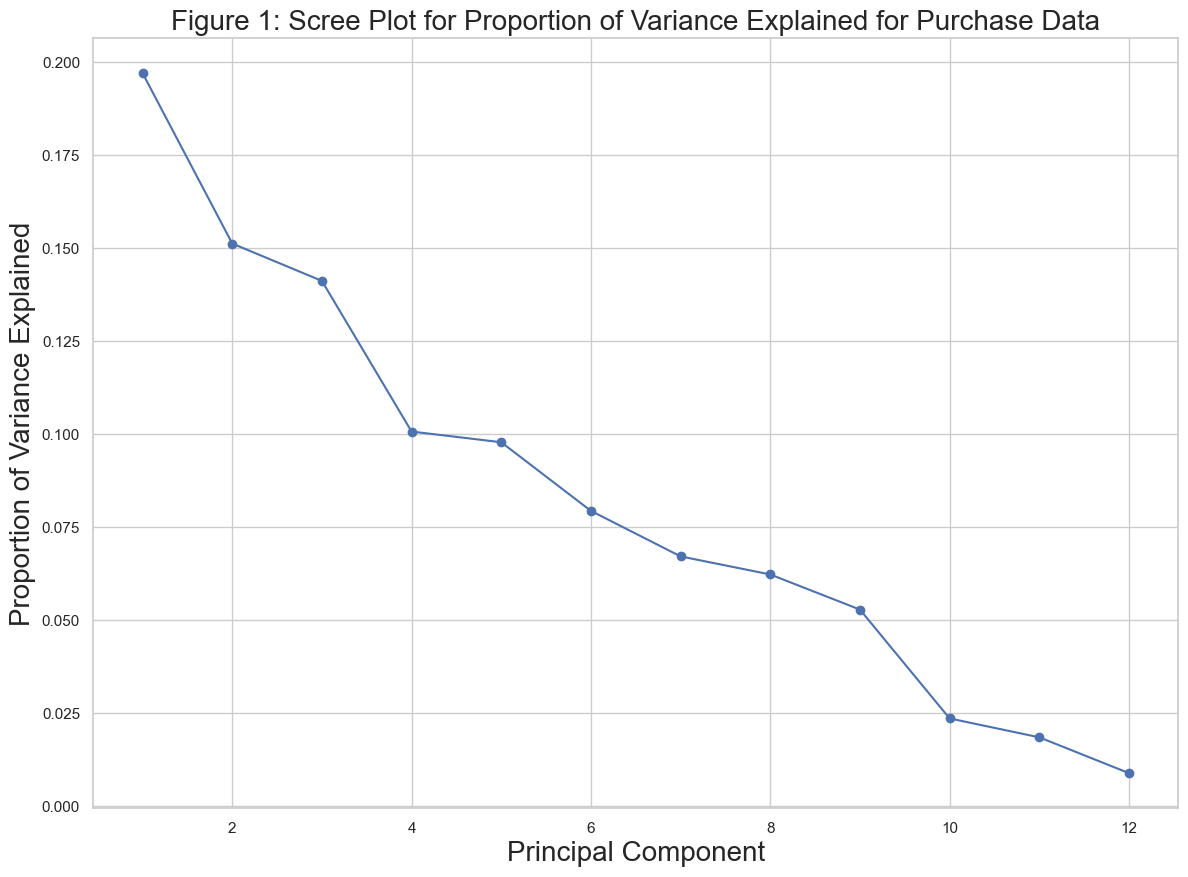

In [51]:
purchase_col_sel = [
  'gender_encoded',
  'maritial_status_encoded',
  'car_ownership_encoded',
  'age_group_encoded',
  'purchase_factors:Aesthetics',
  'purchase_factors:Brand name',
  'purchase_factors:Customisable options',
  'purchase_factors:Functionality',
  'purchase_factors:Price',
  'purchase_factors:Size',
  'purchase_factors:Sustainability/environment considerations',
  'purchase_factors:Technological features'
]
purchase_df = transformed_df[purchase_col_sel]

purchase_factors = transformed_df['purchase_factors'].explode().unique().tolist()
for i, val in enumerate(purchase_factors):
  purchase_factors[i] = 'purchase_factors:' + val

scaler = MinMaxScaler()
scaled_purchase_df = pd.DataFrame(data = scaler.fit_transform(purchase_df), columns = purchase_df.columns)

# reduced
reduced_purchase_df = scaled_purchase_df.copy()
pca = PCA()
pca.fit(reduced_purchase_df)

eigenvalues = pca.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

plt.figure(figsize=(14,10))
plt.plot(np.arange(1, len(prop_var)+1), 
                   prop_var, marker='o')
plt.xlabel('Principal Component',
           size = 20)
plt.ylabel('Proportion of Variance Explained',
           size = 20)
plt.title('Figure 1: Scree Plot for Proportion of Variance Explained for Purchase Data',
          size = 20)
plt.grid(True)

reduced_purchase_df = PCA(n_components=10).fit_transform(reduced_purchase_df)
reduced_purchase_df = pd.DataFrame(reduced_purchase_df)

## Customised Components Data


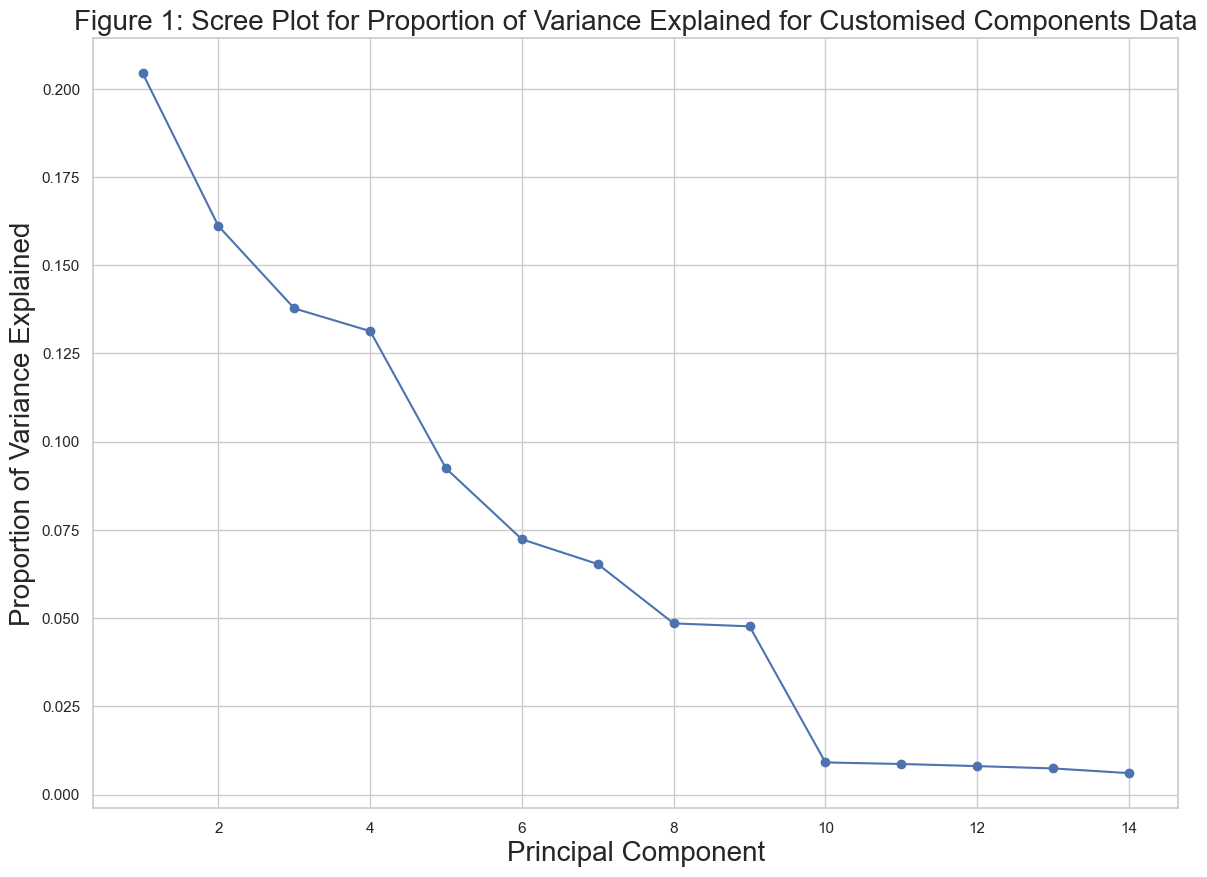

In [52]:
# Data Selection
customise_col_sel = [
  'exterior_components:Brakes',
  'exterior_components:Bumpers',
  'exterior_components:Grilles',
  'exterior_components:Headlights',
  'exterior_components:Side mirrors',
  'exterior_components:Wheels',
  'exterior_components:add body kit and change the exhaust and tune the engine',
  'exterior_components:doors',
  'interior_components:Centre compartment',
  'interior_components:Dashboard',
  'interior_components:Door handles',
  'interior_components:Steering wheel',
  'interior_components:Sun blocker for front passengers',
  'interior_components:air vent', 
  'customise_spend_encoded',
  'personalise_spend_encoded'
]
customise_df = transformed_df[customise_col_sel]

interior_components = transformed_df['interior_components'].explode().unique().tolist()
for i, val in enumerate(interior_components):
  interior_components[i] = 'interior_components:' + val
exterior_components = transformed_df['exterior_components'].explode().unique().tolist()
for i, val in enumerate(exterior_components):
  exterior_components[i] = 'exterior_components:' + val

# Scaling Min MAx
scaler = MinMaxScaler()
scaled_customise_df = pd.DataFrame(data = scaler.fit_transform(customise_df), columns = customise_df.columns)

# reduced
reduced_customise_df = scaled_customise_df.copy()
reduced_customise_df.drop(columns=['customise_spend_encoded', 'personalise_spend_encoded'], inplace=True)
pca = PCA()
pca.fit(reduced_customise_df)

eigenvalues = pca.explained_variance_
prop_var = eigenvalues / np.sum(eigenvalues)

plt.figure(figsize=(14,10))
plt.plot(np.arange(1, len(prop_var)+1), 
                   prop_var, marker='o')
plt.xlabel('Principal Component',
           size = 20)
plt.ylabel('Proportion of Variance Explained',
           size = 20)
plt.title('Figure 1: Scree Plot for Proportion of Variance Explained for Customised Components Data',
          size = 20)
plt.grid(True)

reduced_customise_df = PCA(n_components=10).fit_transform(reduced_customise_df)
reduced_customise_df = pd.concat([scaled_customise_df.loc[:,['customise_spend_encoded', 'personalise_spend_encoded']], pd.DataFrame(reduced_customise_df)], axis=1)

# Data Visualisation

In [53]:
import seaborn as sns

In [54]:
def important_factors(group_df, title):
    purchase_cols = [col for col in group_df.columns if 'purchase' in col]
    purchase_counts = group_df[purchase_cols].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=purchase_counts.values, y=purchase_counts.index, hue=purchase_counts.index, palette='viridis')
    plt.title(f'Most Important Purchase Factors - {title}')
    plt.xlabel('Count')
    plt.ylabel('Purchase Factors')
    plt.show()

## Purchase Factors

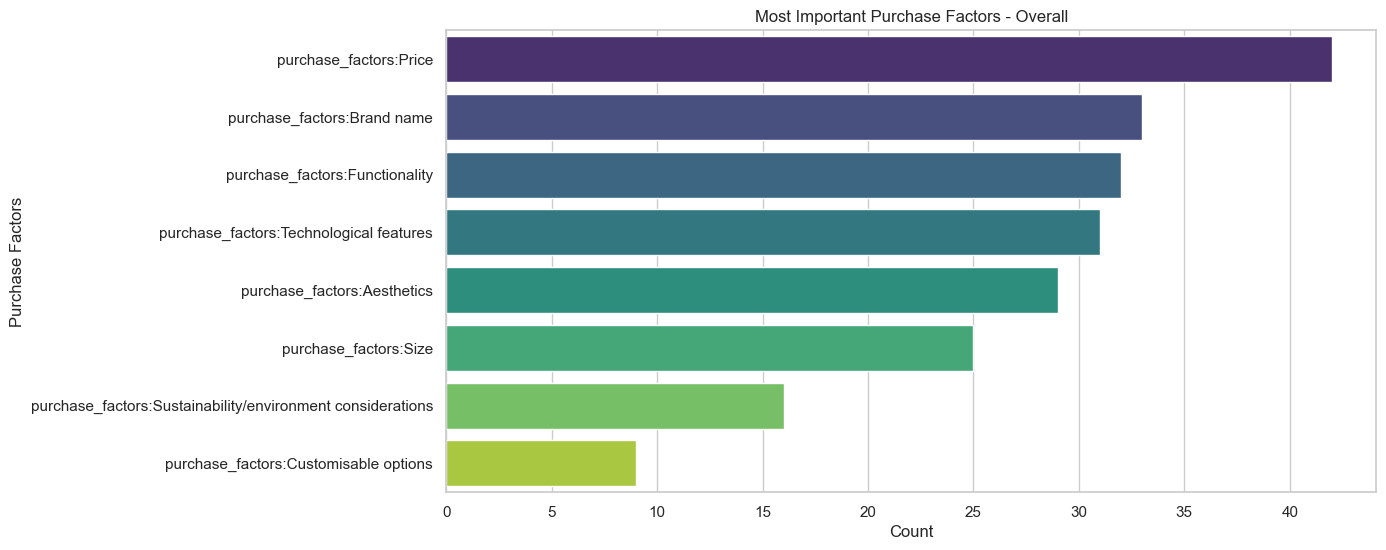

In [55]:
important_factors(purchase_df, 'Overall')

In [56]:
no_car_df = purchase_df[transformed_df['car_ownership_encoded'] == 0]
own_car_df = purchase_df[transformed_df['car_ownership_encoded'] > 0]

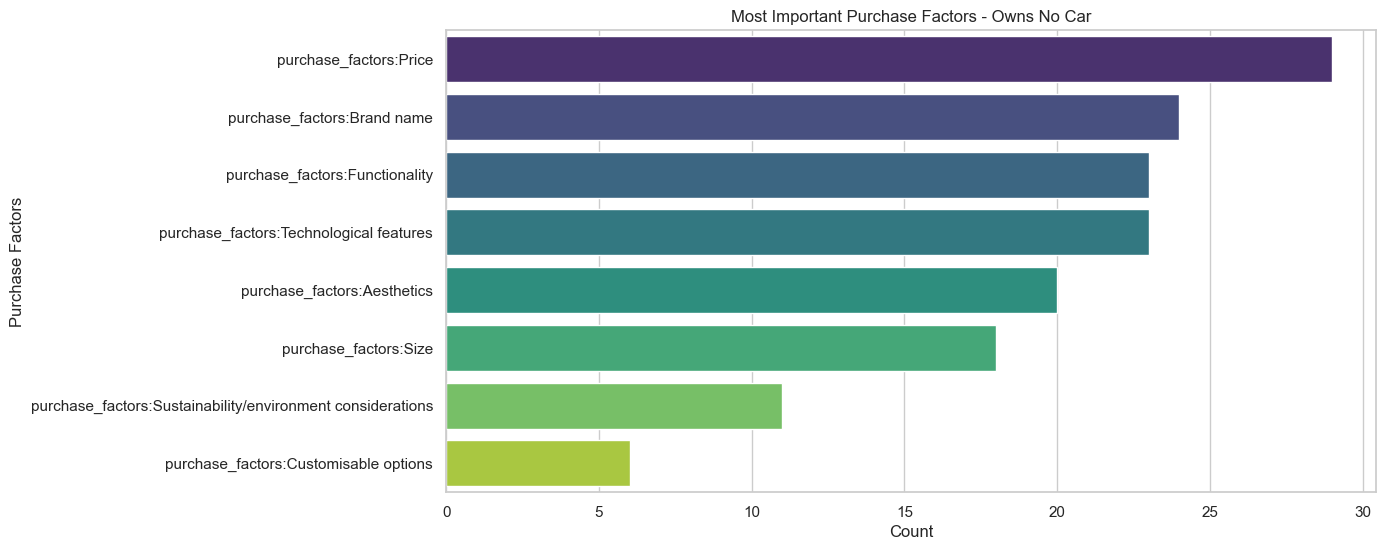

In [57]:
important_factors(no_car_df, 'Owns No Car')

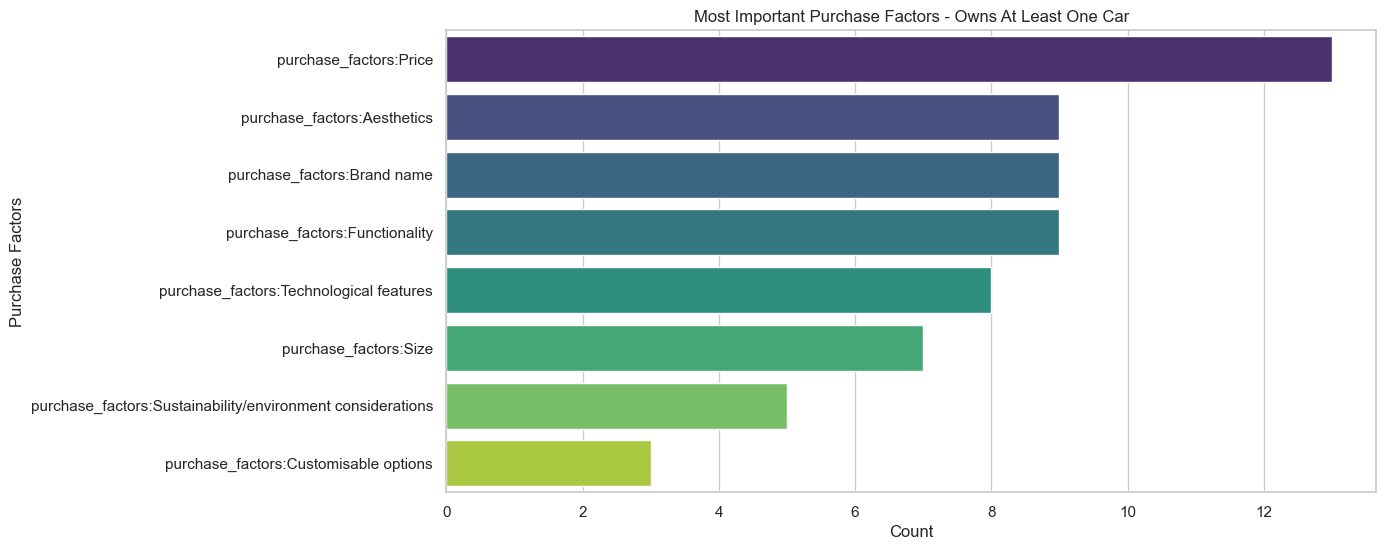

In [58]:
important_factors(own_car_df, 'Owns At Least One Car')

## Customisation Data

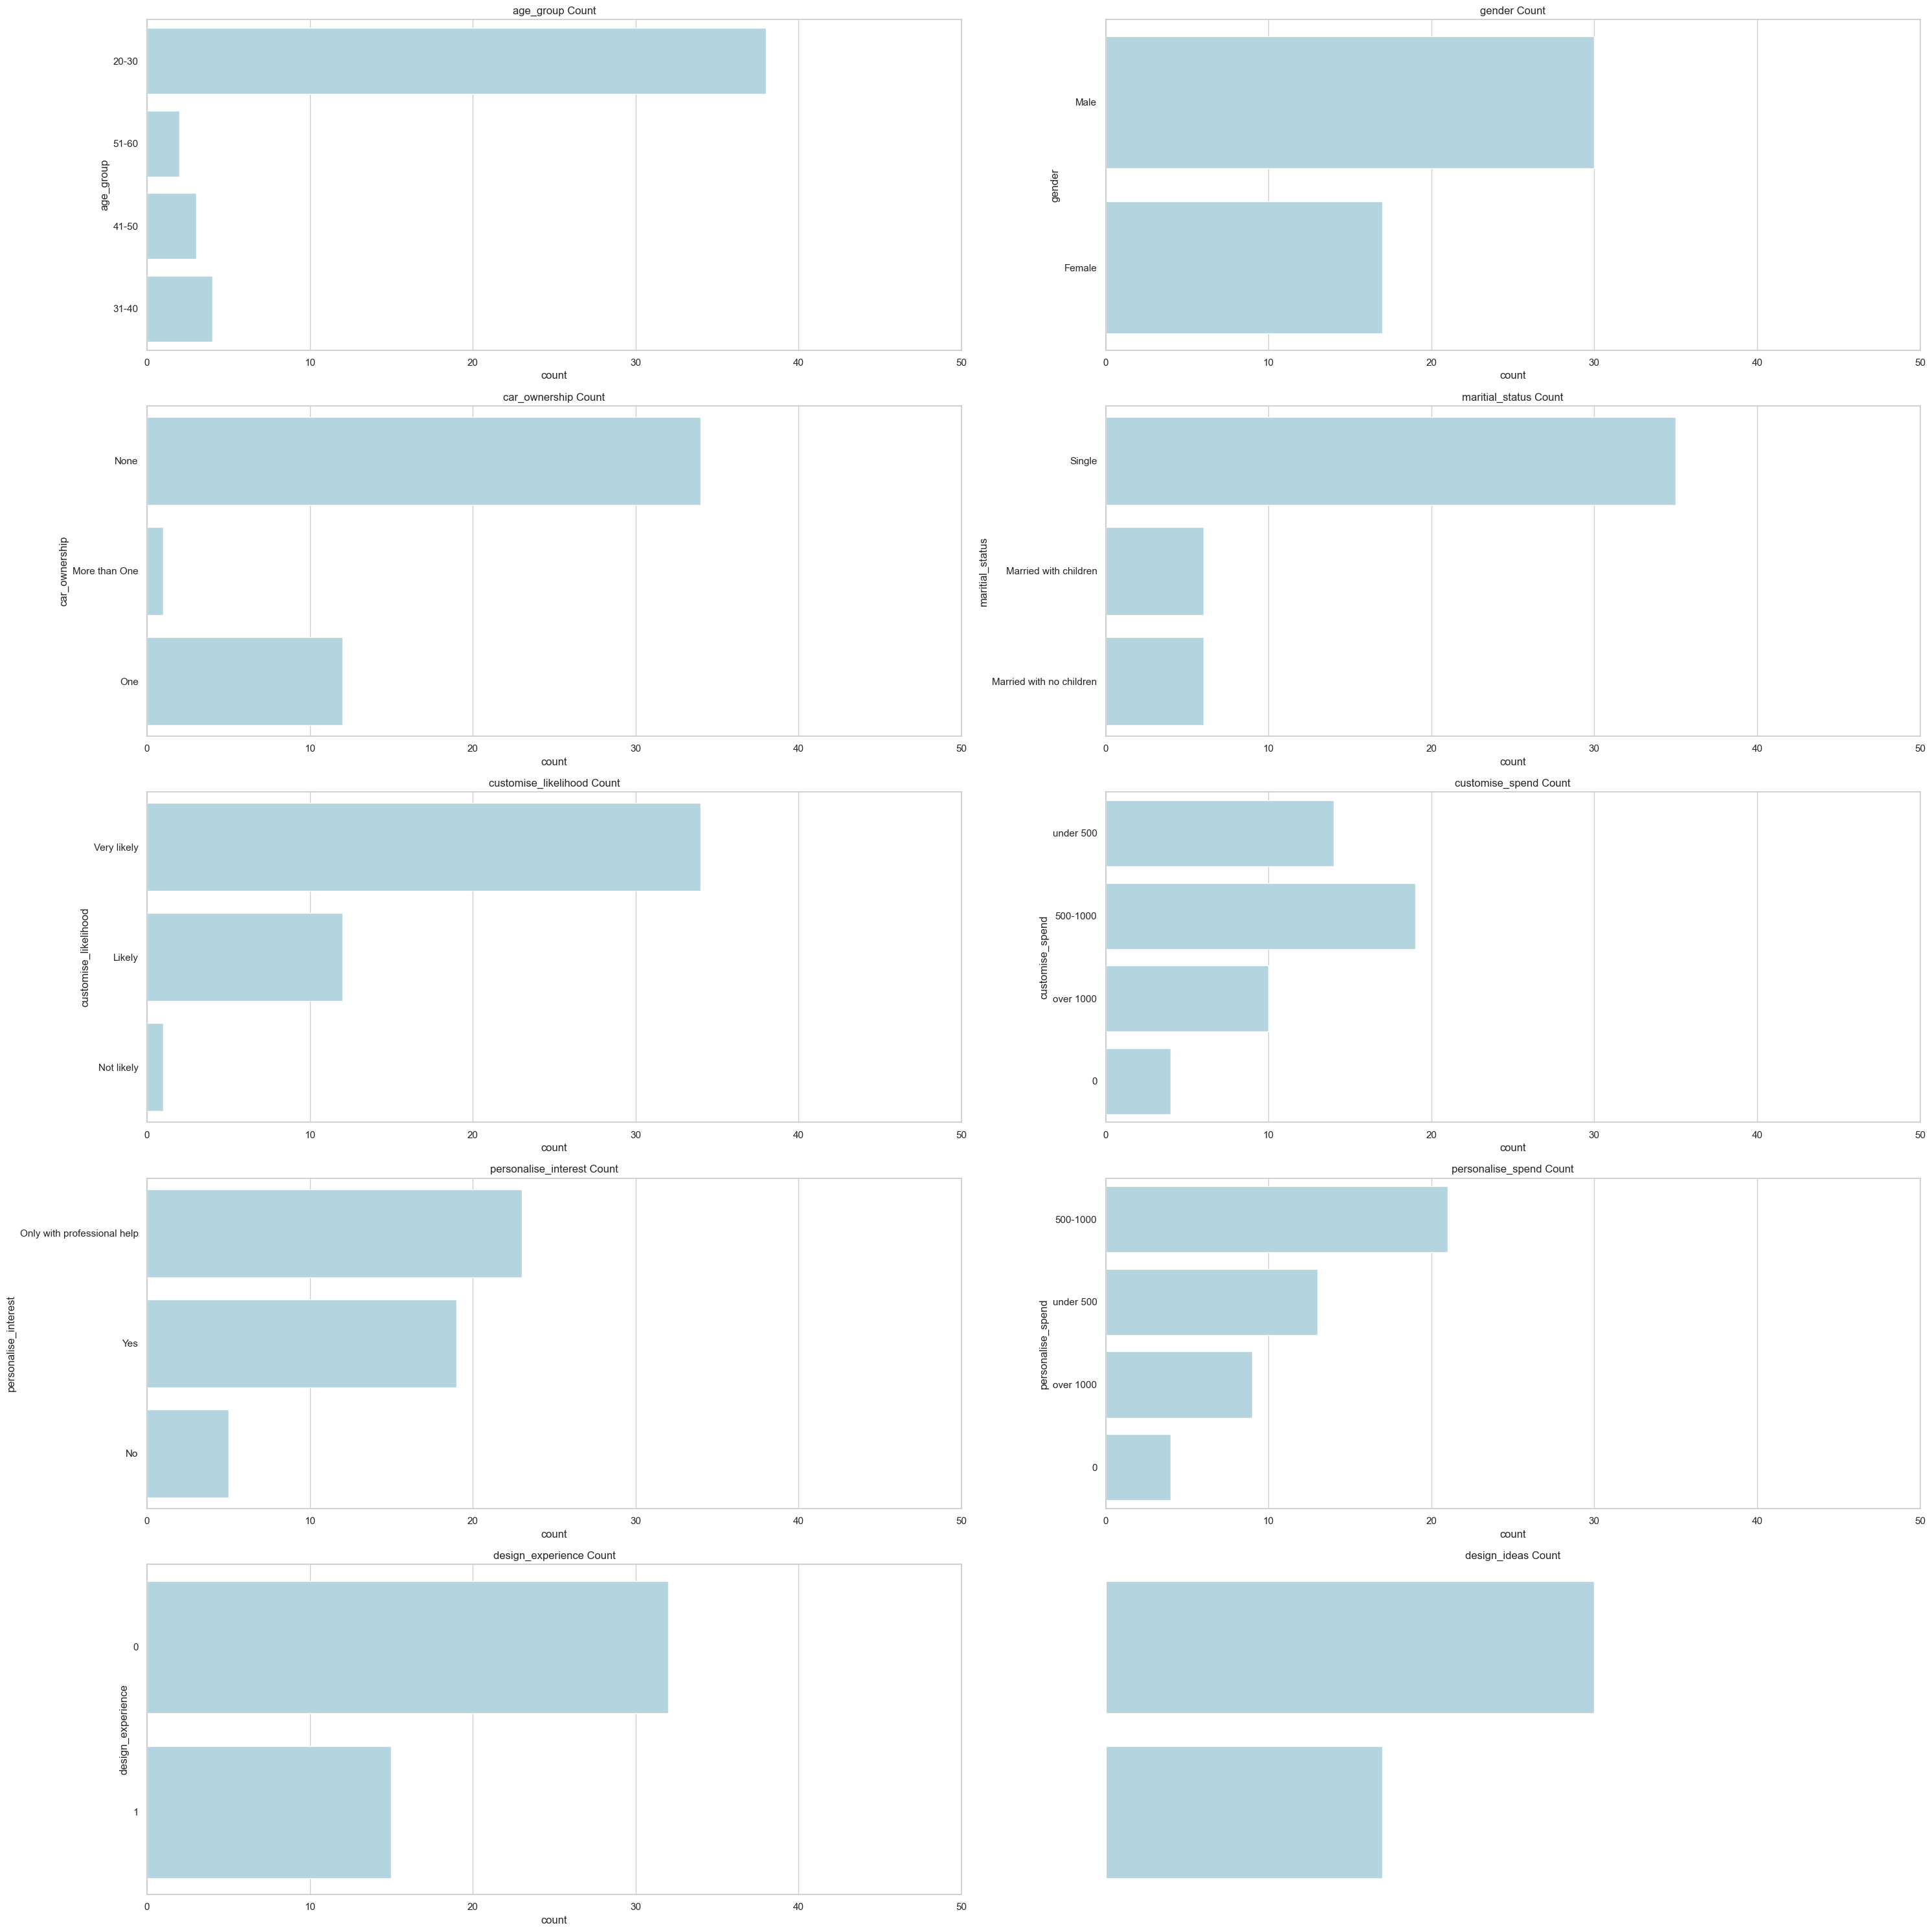

In [59]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(nrows=5, ncols=2,figsize=(30, 30))
plt.axis('off')
ax = ax.flatten()
select_columns = ['age_group', 'gender',
                  'car_ownership', 'maritial_status', 
                  'customise_likelihood', 'customise_spend', 
                  'personalise_interest', 'personalise_spend',
                  'design_experience', 'design_ideas']
for i, col in enumerate(select_columns):
  sns.countplot(data=transformed_df, y=col, ax=ax[i], color='lightblue')
  ax[i].set_title(f'{col} Count')
  ax[i].set_xlim(0,50)
plt.tight_layout()
plt.show()

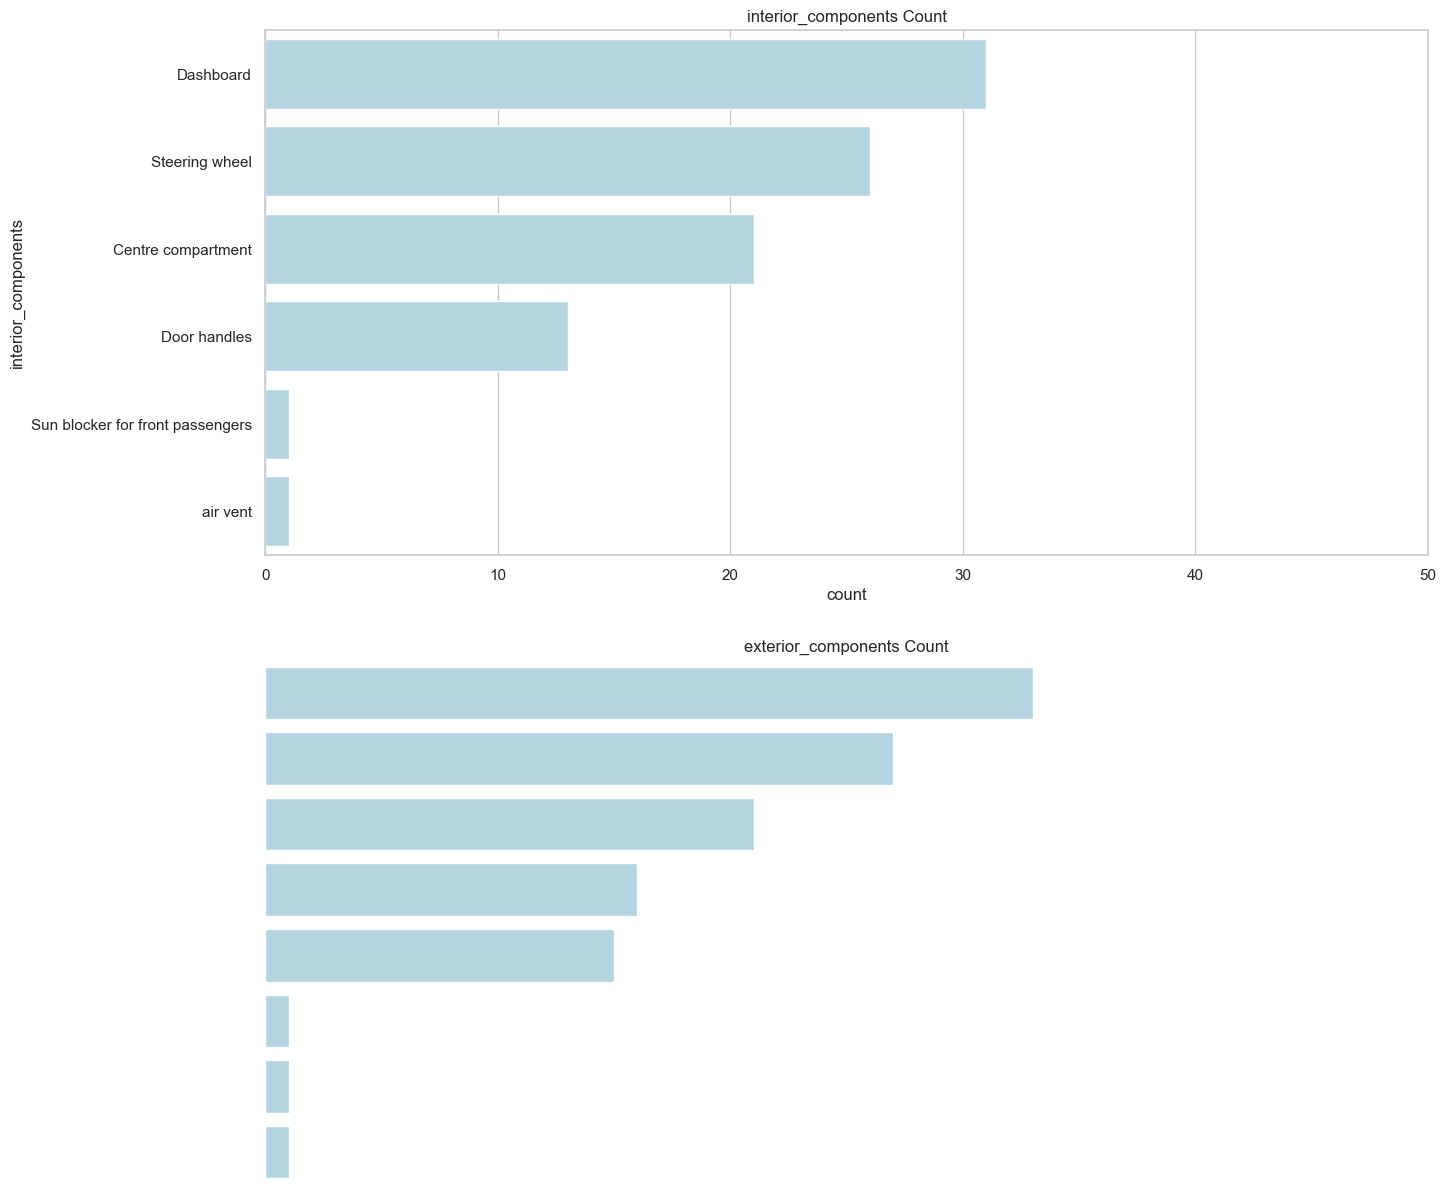

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15, 15))
plt.axis('off')
ax = ax.flatten()
select_columns = ['interior_components', 
                  'exterior_components']
for i, col in enumerate(select_columns):
  sns.barplot(data=transformed_df[col].explode().value_counts(), orient='h', ax=ax[i], color='lightblue')
  ax[i].set_title(f'{col} Count')
  ax[i].set_xlim(0,50)
plt.show()

# Data Clustering

In [73]:
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error

In [74]:
component_cols = interior_components + exterior_components

In [75]:
def optimise_k(data, max_k, title):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters = k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    #Generating an elbow plot
        
    fig = plt.subplots(figsize = (10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel('Number of CLusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.title(title)
    plt.show()

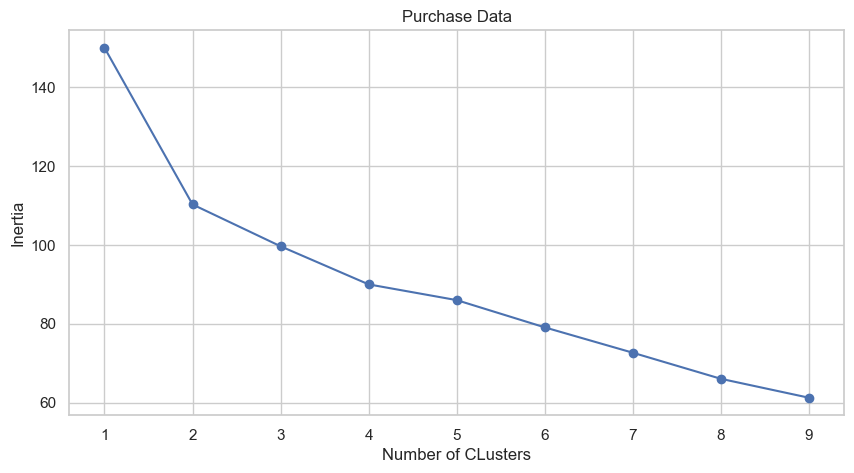

In [81]:
optimise_k(purchase_df, 10, 'Purchase Data')

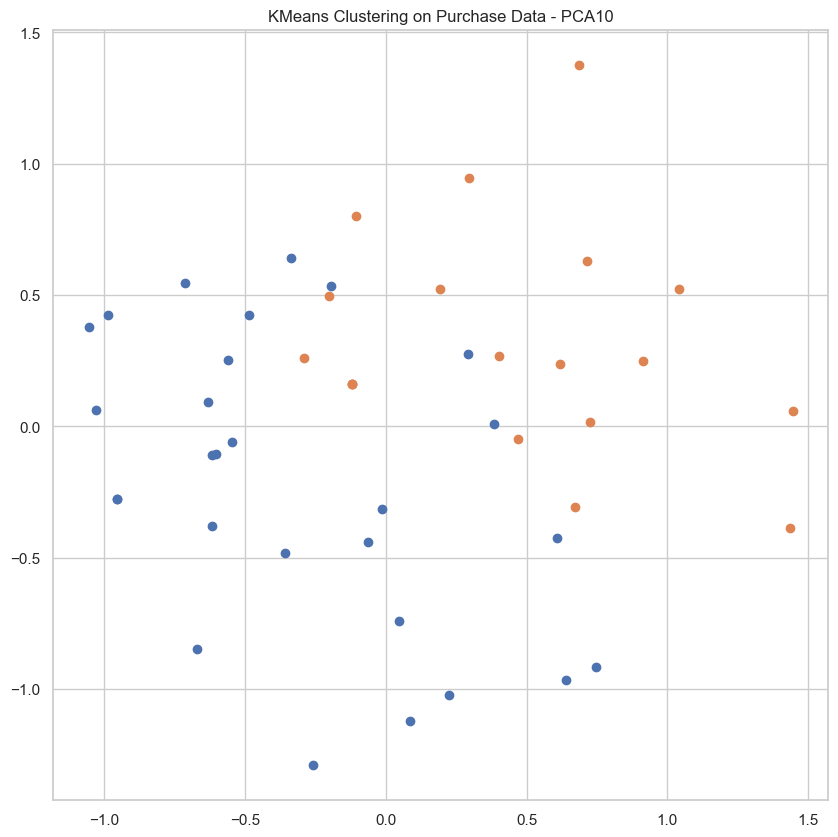

In [84]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(reduced_purchase_df.to_numpy())

u_labels = np.unique(clusters)
 
fig = plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(reduced_purchase_df.to_numpy()[clusters == i , 0] , reduced_purchase_df.to_numpy()[clusters == i , 1] , label = i)
plt.title('KMeans Clustering on Purchase Data - PCA10')
plt.show()

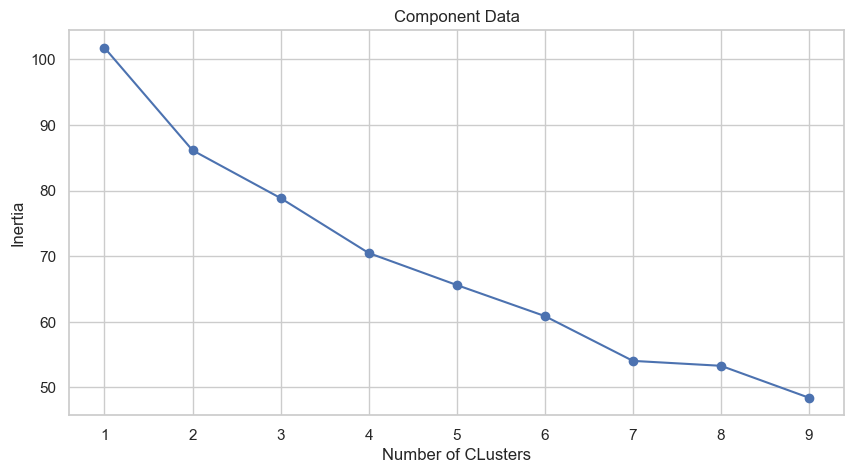

In [79]:
optimise_k(customise_df[component_cols], 10, 'Component Data')

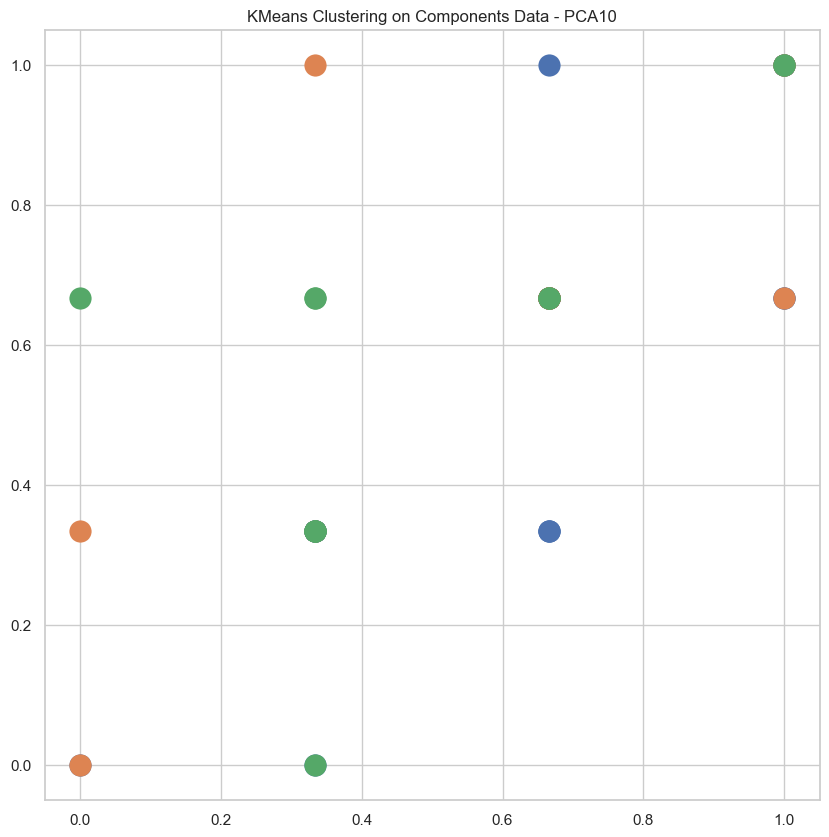

In [95]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(reduced_customise_df.drop(['customise_spend_encoded','personalise_spend_encoded'], axis=1).to_numpy())

u_labels = np.unique(clusters)
 
fig = plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(reduced_customise_df.to_numpy()[clusters == i , 0] , reduced_customise_df.to_numpy()[clusters == i , 1] , label = i, linewidths=10)
plt.title('KMeans Clustering on Components Data - PCA10')
plt.show()

# Data Classification


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix,classification_report

In [ ]:
classification_models = [DecisionTreeClassifier(), RandomForestClassifier(), ExtraTreesClassifier()]
regression_models = [LogisticRegression(), GaussianNB(), KNeighborsClassifier(), RandomForestRegressor()]
def model_evaluation(model, X_train, X_test, y_train, y_test, print_results=True):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  if print_results:
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
    print(f"Precision Score: \n{precision_score(y_test, y_pred, average='weighted')}")
    print(f"Recall Score: {recall_score(y_test, y_pred, average='weighted')}")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
  # tp, fn, fp, tn = confusion_matrix(y_test,y_pred).reshape(-1)
  accuracy = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred, average='weighted')
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  model_dict={'Model': [model.__class__.__name__], 'Accuracy': [round(accuracy,3)], 'F1_Score': [round(f1,3)], 'Precision': [round(precision,3)], 'Recall': [round(recall,3)]}
  try:
    model_df = pd.DataFrame(data=model_dict)
  except:
    print("Error creating model_df")
    print(model_dict)
    return
  return model, model_df

In [ ]:
def analyze_components_importance_classification_rf(X_train, X_test, y_train, y_test, components_cols, title, selected_model):
    model = selected_model
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    feature_importance = model.feature_importances_

    # visualize feature importance
    importance_df = pd.DataFrame({'Feature': components_cols, 'Importance': feature_importance})

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
    plt.title(f'Components Importance ({model.__class__.__name__}) - {title} (Accuracy: {accuracy})')
    plt.show()

    # print(f'Classification Report:\n{report}')

### Components Data


In [ ]:
X = customise_df[component_cols]
y = customise_df['customise_spend_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
res = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_Score', 'Precision', 'Recall'])
customised_vehicle_likelihood_model = {}
for model in classification_models:
  model_res, model_df = model_evaluation(model, X_train, X_test, y_train, y_test, False)
  res = pd.concat([res, model_df], ignore_index=True)
  customised_vehicle_likelihood_model[model.__class__.__name__] = model_res
  del model_res
  del model_df
res = res.sort_values(by='Accuracy', ascending=False)
res = res.reset_index(drop=True)
display(res)

/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/folders/bt/pg056kkx3wx3rkfyhvzh2lwh0000gn/T/ipykernel_99369/1594455060.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res = pd.concat([res, model_df], ignore_index=True)
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined a

,Model,Accuracy,F1_Score,Precision,Recall
0,ExtraTreesClassifier,0.1,0.133,0.2,0.1
1,DecisionTreeClassifier,0.0,0.000,0.0,0.0
2,RandomForestClassifier,0.0,0.000,0.0,0.0


/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

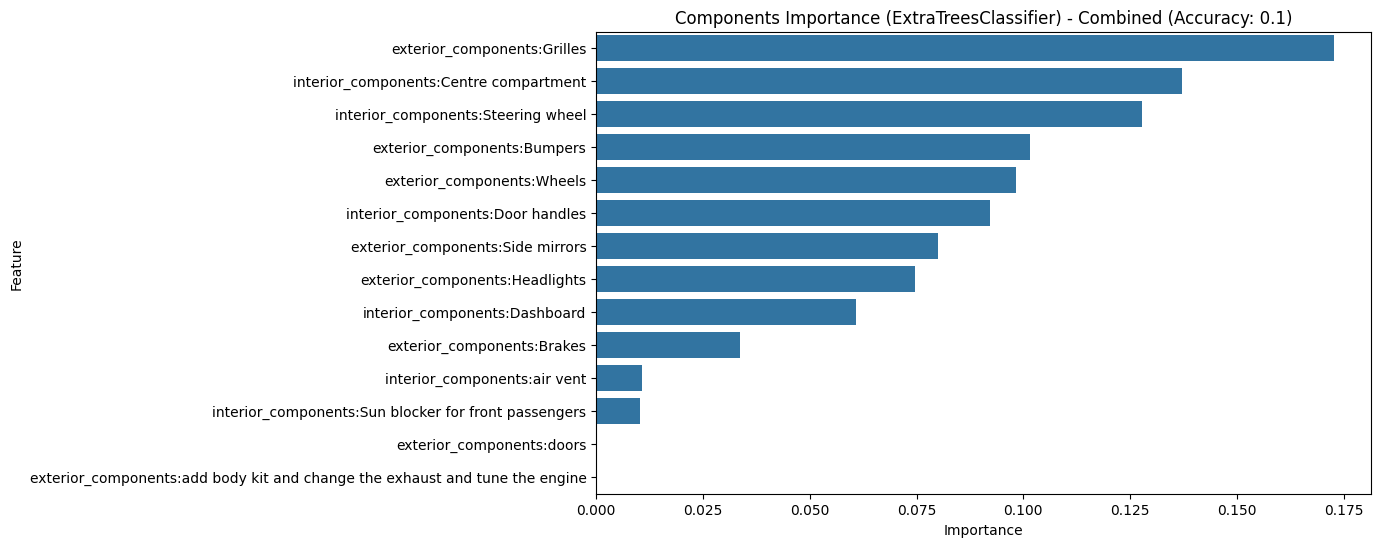

In [ ]:
analyze_components_importance_classification_rf(X_train, X_test, y_train, y_test, component_cols, 'Combined', ExtraTreesClassifier())

/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bentjh01/Documents/01_NTU/Sem_8/MA4829_Machine_Intelligence/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samp

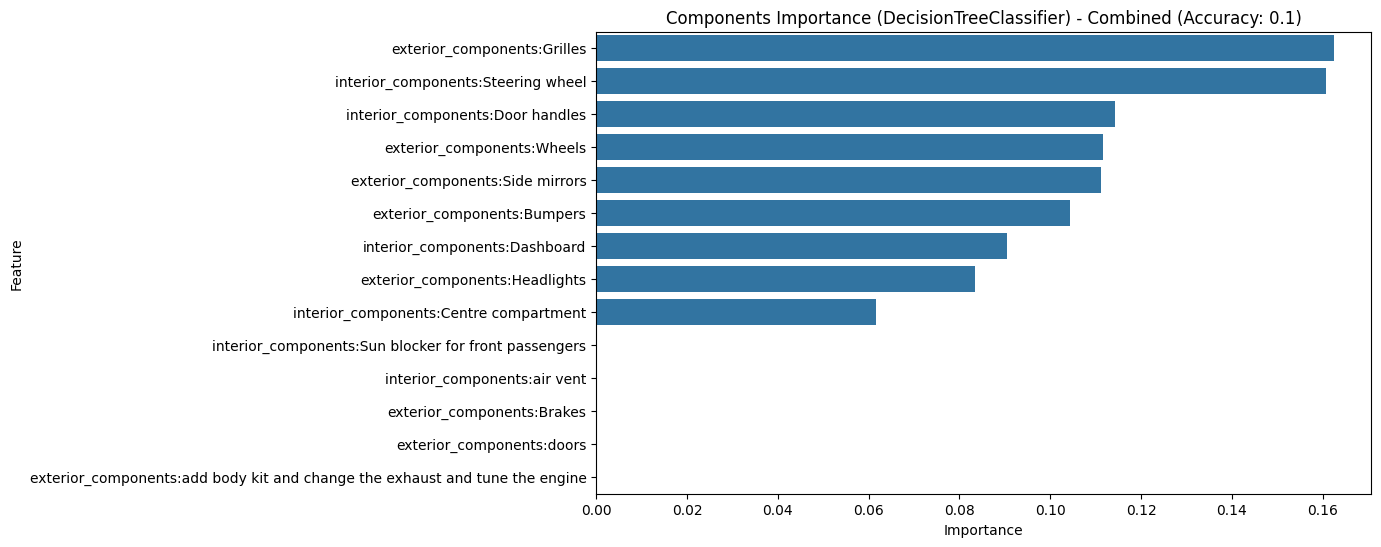

In [ ]:
analyze_components_importance_classification_rf(X_train, X_test, y_train, y_test, component_cols, 'Combined', DecisionTreeClassifier())

In [ ]:
asdfasfasf

NameError: name 'asdfasfasf' is not defined

afsdfasdggasdga


In [ ]:
data_raw_df.describe()

,Which age group do you belong to?,What is your gender?,Which category do you currently belong to?,Which of the following best describes you?,Which of these factors are important to you when deciding which car to purchase?,How likely are you to opt for customised vehicle if there were no extra charges?,"Which of the following exterior components would you choose to customise (texture, layout, size, etc)?","Which of the following interior components would you choose to customise (texture, layout, size, etc)?",How much are you willing to spend on car customisation if surcharges are applicable?,Are you interested in designing your own components to personalise your car?,How much are you willing to pay for the personalised design?,"Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)",Please give us any design ideas to make the car uniquely Singaporean.
count,50,50,50,50,49,50,49,50,50,50,50,50,17
unique,4,3,3,3,37,3,23,16,5,3,4,2,17
top,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Very likely,Wheels,Dashboard,500-1000,Only with professional help,500-1000,"No, I would need a designer to model my sketch",wheels that look like the singapore flyer
freq,41,32,36,38,5,37,8,11,19,26,21,33,1


In [ ]:
for column_name in data_raw_df.columns:
    print(column_name)
    print(data_raw_df[column_name].unique())
    print("")

Which age group do you belong to?
['20-30' '51-60' '41-50' '31-40']

What is your gender?
['Male' 'Female' 'Prefer not to say']

Which category do you currently belong to?
['Do not own a car, but planning to purchase in future'
 'Own more than one car' 'Own a car']

Which of the following best describes you?
['Single' 'Married with children' 'Married with no children']

Which of these factors are important to you when deciding which car to purchase?
['Price;Functionality;Size;Customisable options'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size;Sustainability/environment considerations'
 'Aesthetics;Functionality;Customisable options'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size;Customisable options;Sustainability/environment considerations'
 'Price;Brand name;Aesthetics;Technological features;Functionality'
 'Price;Brand name;Aesthetics;Technological features;Functionality;Size'
 'Price;Technological features;Functionality'
 'Price;Br

In [ ]:
# Data Cleaning
# To change the keys (column names) of multiple columns:
data_mod_df = data_raw_df.copy()
data_mod_df.rename(columns={'Which age group do you belong to?': 'age_group', 
                            'What is your gender?': 'gender', 
                            "Which category do you currently belong to?": "car_ownership_status",
                            "Which of the following best describes you?": "maritial_status",
                            "Which of these factors are important to you when deciding which car to purchase?": "purchase_factors",
                            "How likely are you to opt for customised vehicle if there were no extra charges? ": "customsied_vehicle_likelihood",
                            "Which of the following exterior components would you choose to customise (texture, layout, size, etc)? ": "exterior_components_customisation",
                            "Which of the following interior components would you choose to customise (texture, layout, size, etc)? ": "interior_components_customisation",
                            "How much are you willing to spend on car customisation if surcharges are applicable?": "customisation_spend",
                            "Are you interested in designing your own components to personalise your car? ": "customisation_interest",
                            "How much are you willing to pay for the personalised design? ": "personalised_design_spend",
                            "Do you have any 3D design experience that would help with the design process? (e.g. AutoCAD, SolidWorks, Blender, etc)": "3D_design_experience",
                            "Please give us any design ideas to make the car uniquely Singaporean.": "design_ideas"
                            }, inplace=True)
data_mod_df.head()


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,personalised_design_spend,3D_design_experience,design_ideas
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,500-1000,"No, I would need a designer to model my sketch",NaN
1,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Likely,Wheels;Grilles;Headlights;Side mirrors,Centre compartment,under 500,Only with professional help,under 500,"No, I would need a designer to model my sketch",wheels that look like the singapore flyer
2,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Aesthetics;Functionality;Customisable options,Very likely,Wheels;Grilles;Headlights;Side mirrors,Steering wheel;Dashboard,500-1000,Yes,500-1000,"Yes, I can design on my own",NaN
3,20-30,Female,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Very likely,Wheels;Grilles;Headlights;Side mirrors;Bumpers,Steering wheel;Centre compartment;Door handles...,under 500,Yes,under 500,"No, I would need a designer to model my sketch",NaN
4,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Brand name;Aesthetics;Technological feat...,Very likely,Wheels;Grilles;Headlights;Bumpers,Steering wheel;Centre compartment,over 1000,Only with professional help,over 1000,"No, I would need a designer to model my sketch",Sg flag/ colour related car paint


In [ ]:
# print(data_mod_df["purchase_factors"][1])
# data_mod_df.loc[1, "purchase_factors"] = 1
# print(data_mod_df["purchase_factors"][1])

In [ ]:
print('stop')

stop


In [ ]:
def find_unique_values(df, column_name, delmiter):
    unique_values = []
    for values in df[column_name].unique():
        if values is np.nan:
            continue
        _ = values.split(delmiter)
        for value in _:
            if value not in unique_values:
                unique_values.append(value)
    return unique_values

In [ ]:
purchase_factors_unique = find_unique_values(data_mod_df, "purchase_factors", ";")
for factor in purchase_factors_unique:
  data_mod_df[factor] = data_mod_df["purchase_factors"].str.contains(factor)
data_mod_df.head(1)


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,...,3D_design_experience,design_ideas,Price,Functionality,Size,Customisable options,Brand name,Aesthetics,Technological features,Sustainability/environment considerations
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,...,"No, I would need a designer to model my sketch",NaN,True,True,True,True,False,False,False,False


In [ ]:
exterior_components_unique = find_unique_values(data_mod_df, "exterior_components_customisation", ";")
for components in exterior_components_unique:
  data_mod_df[components] = data_mod_df["exterior_components_customisation"].str.contains(components)
data_mod_df.head(1)


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,...,Technological features,Sustainability/environment considerations,Grilles,Wheels,Headlights,Side mirrors,Bumpers,Brakes,doors,add body kit and change the exhaust and tune the engine
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,...,False,False,True,False,False,False,False,False,False,False


In [ ]:
interior_components_unique = find_unique_values(data_mod_df, "interior_components_customisation", ";")
for components in interior_components_unique:
  data_mod_df[components] = data_mod_df["interior_components_customisation"].str.contains(components)
data_mod_df.head(1)


,age_group,gender,car_ownership_status,maritial_status,purchase_factors,customsied_vehicle_likelihood,exterior_components_customisation,interior_components_customisation,customisation_spend,customisation_interest,...,Bumpers,Brakes,doors,add body kit and change the exhaust and tune the engine,Centre compartment,Steering wheel,Dashboard,Door handles,Sun blocker for front passengers,air vent
0,20-30,Male,"Do not own a car, but planning to purchase in ...",Single,Price;Functionality;Size;Customisable options,Very likely,Grilles,Centre compartment,100-500,Only with professional help,...,False,False,False,False,True,False,False,False,False,False


In [ ]:
from fuzzywuzzy import fuzz

# Define a function to calculate fuzzy match score
def fuzzy_match_score(str1, str2):
    return fuzz.ratio(str1, str2)

# Apply fuzzy match score on a column of the dataframe
new_df = data_raw_df.copy()
new_df['Fuzzy Score'] = data_raw_df['How likely are you to opt for customised vehicle if there were no extra charges?'].apply(lambda x: fuzzy_match_score(x, 'Target_String'))


ModuleNotFoundError: No module named 'fuzzywuzzy'